In [1]:
from tqdm.notebook import tqdm
from importlib import reload
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time
import utilitaires
from utilitaires import psnr_from_model, load_data, train_model, function_for_comparison, plot_result, affiche_images

from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
import SimpleITK 
import skimage.io as io

import numpy as np

In [2]:
CT = True               # Training with CT data or not
upscale = 2                     # Upscale factor (U) = 4
window_size = 16                 # Window size (W)
patch_size = 4 
embed_dim = 96                  # Embedding dimension (D) = 96
num_heads = [3,6]             # Default chosen in the document [3,6,12,24]
depths = [6, 6]                        # Number of encoder layers (L) = 4
output_channels = 1                # Number of channels for output images
input_size = 64  
shift_size = window_size // 2   #  Shift size (S)
num_features = 64   
mlp_ratio = 2.  


epochs = 300             # Number of epochs
base_lr = 8e-4          # Base LR
batch_size = 64         # Penser à rendre le 64 normal
loss_fn = nn.MSELoss()


device = 'cpu'
#input_channels = 2 if CT else 1  # Number of channels for input images
input_channels =2


In [3]:
# Download data
type_data = ["low_edep", "high_edep", "ct"]
low_samp_data = load_data("MCsimulations", type_data[0])
high_samp_data = load_data("MCsimulations", type_data[1])
if CT:
    ct_data = load_data("MCsimulations", type_data[2])

# Transform data into tensors
low_samp_tensors = [torch.from_numpy(x).to(torch.float32) for x in low_samp_data]
high_samp_tensors = [torch.from_numpy(x).to(torch.float32) for x in high_samp_data]
if CT:
    ct_tensors = [torch.from_numpy(x).to(torch.float32) for x in ct_data]

In [4]:
import random

# List of patient indices from 1 to 82
index_patients = list(range(0, 82))

# Set the random seed for reproducibility
random.seed(1)

# Shuffle the list of patient indices
random.shuffle(index_patients)

# Assign indices to training, validation, and test sets
train_index = index_patients[:58]
val_index = index_patients[58:58+16]
test_index = index_patients[58+16:]

# Initialize lists to store training, validation, and test data
Low_train = []
High_train = []
CT_train = []

Low_val = []
High_val = []
CT_val = []

Low_test = []
High_test = []
CT_test = []

# Populate training data
for i in train_index:
    Low_train.extend(low_samp_tensors[i*80: (i+1)*80])
    High_train.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_train.extend(ct_tensors[i*80: (i+1)*80])

# Populate validation data
for i in val_index:
    Low_val.extend(low_samp_tensors[i*80: (i+1)*80])
    High_val.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_val.extend(ct_tensors[i*80: (i+1)*80])

# Populate test data
for i in test_index:
    Low_test.extend(low_samp_tensors[i*80: (i+1)*80])
    High_test.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_test.extend(ct_tensors[i*80: (i+1)*80])

print(f"The train data size is : {len(Low_train)}")
print(f"The validation data size is : {len(Low_val)}")
print(f"The test data size is : {len(Low_test)}")

The train data size is : 4640
The validation data size is : 1280
The test data size is : 640


In [5]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, low, high, ct=None):
        self.low = low
        self.high = high
        self.ct = ct

    def __len__(self):
        return len(self.low)

    def __getitem__(self, idx):
        X = self.low[idx]
        y = self.high[idx]
        
        if self.ct is not None:
            X = torch.stack([self.low[idx], self.ct[idx]], dim=0)
        
        return X, y
    
# DataLoader
if CT:
    dataloader_train = DataLoader(dataset=CustomDataset(Low_train, High_train, CT_train), 
                                batch_size=batch_size, shuffle=True)
    dataloader_val = DataLoader(dataset=CustomDataset(Low_val, High_val, CT_val), 
                                batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset=CustomDataset(Low_test, High_test, CT_test),
                                batch_size=batch_size, shuffle=True)
else :
    dataloader_train = DataLoader(dataset=CustomDataset(Low_train, High_train), 
                                batch_size=batch_size, shuffle=True)
    dataloader_val = DataLoader(dataset=CustomDataset(Low_val, High_val), 
                                batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset=CustomDataset(Low_test, High_test),
                                batch_size=batch_size, shuffle=True)

## WITHOUT CT

In [260]:
# Définition des modèles
### SUNet CT at beginning
CT = False
input_channels = 1
embed_dim = 96
num_heads = [3,6] 
from Models_Architectures import SUNet_CT_inside
model_sunet_without_ct = SUNet_CT_inside.SUNet(img_size=input_size, patch_size=patch_size, input_channels=input_channels, 
                    output_channels=output_channels, embed_dim=embed_dim, depths=depths,
                    num_heads=num_heads, window_size=window_size, mlp_ratio=mlp_ratio, CT=CT,
                    qkv_bias=True, qk_scale=2, drop_rate=0., attn_drop_rate=0., 
                    drop_path_rate=0.1, norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                    use_checkpoint=False, final_upsample="Dual up-sample")
model_sunet_without_ct.to(device)

# Optimiser
optimizer = torch.optim.Adam(model_sunet_without_ct.parameters(), lr=base_lr)

print('FLOPs: %.4f G' % (model_sunet_without_ct.flops() / 1e9))
print('Number of parameters: %d' % (sum(p.numel() for p in model_sunet_without_ct.parameters())))
# print('Models parameters : ', model_sunet_without_ct)



FLOPs: 0.3544 G
Number of parameters: 3315917


In [261]:
reload(utilitaires)
path = "Saved_models/model_sunet_100epochs_16windowsize.pth"
print(path)

Saved_models/model_sunet_100epochs_16windowsize.pth


In [262]:
model_sunet_without_ct.load_state_dict(torch.load(path))
print('Number of parameters: %d' % (sum(p.numel() for p in model_sunet_without_ct.parameters())))

Number of parameters: 3315917


## WITH CT AT BEGINNING

In [263]:
# Définition des modèles
### SUNet CT at beginning
CT = True
input_channels = 2
embed_dim = 96
num_heads = [3,6] 
from Models_Architectures import SUNet_CT_beginning
model_sunet_ct_beginning = SUNet_CT_beginning.SUNet(img_size=input_size, patch_size=patch_size, input_channels=input_channels, 
                    output_channels=output_channels, embed_dim=embed_dim, depths=depths,
                    num_heads=num_heads, window_size=window_size, mlp_ratio=mlp_ratio, CT=CT,
                    qkv_bias=True, qk_scale=2, drop_rate=0., attn_drop_rate=0., 
                    drop_path_rate=0.1, norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                    use_checkpoint=False, final_upsample="Dual up-sample")
model_sunet_ct_beginning.to(device)

# Optimiser
optimizer = torch.optim.Adam(model_sunet_ct_beginning.parameters(), lr=base_lr)

print('FLOPs: %.4f G' % (model_sunet_ct_beginning.flops() / 1e9))
print('Number of parameters: %d' % (sum(p.numel() for p in model_sunet_ct_beginning.parameters())))
# print('Models parameters : ', model_sunet_ct_beginning)



FLOPs: 0.3544 G
Number of parameters: 3316781


In [264]:
reload(utilitaires)
path = "Saved_models/model_sunet_300epochs_16windowsize_withCT_at_beginning_v2.pth"
print(path)

Saved_models/model_sunet_300epochs_16windowsize_withCT_at_beginning_v2.pth


In [265]:
model_sunet_ct_beginning.load_state_dict(torch.load(path))
print('Number of parameters: %d' % (sum(p.numel() for p in model_sunet_ct_beginning.parameters())))

Number of parameters: 3316781


## WITH CT INSIDE (AFTER FIRST CONV)

In [266]:
### SUNet CT inside
CT = True
input_channels = 1
embed_dim = 96
num_heads = [3,6] 
from Models_Architectures import SUNet_CT_inside
reload(SUNet_CT_inside)
model_sunet_ct_inside = SUNet_CT_inside.SUNet(img_size=input_size, patch_size=patch_size, input_channels=input_channels, 
                    output_channels=output_channels, embed_dim=embed_dim, depths=depths,
                    num_heads=num_heads, window_size=window_size, mlp_ratio=mlp_ratio, CT=CT,
                    qkv_bias=True, qk_scale=2, drop_rate=0., attn_drop_rate=0., 
                    drop_path_rate=0.1, norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                    use_checkpoint=False, final_upsample="Dual up-sample")
model_sunet_ct_inside.to(device)

# Optimiser
optimizer = torch.optim.Adam(model_sunet_ct_inside.parameters(), lr=base_lr)

print('FLOPs: %.4f G' % (model_sunet_ct_inside.flops() / 1e9))
print('Number of parameters: %d' % (sum(p.numel() for p in model_sunet_ct_inside.parameters())))
# print('Models parameters : ', model_sunet_ct_inside)


FLOPs: 0.3548 G
Number of parameters: 3317462


In [267]:
reload(utilitaires)
path = "Saved_models/model_sunet_300epochs_16windowsize_withCT_after_1st_conv.pth"
print(path)

Saved_models/model_sunet_300epochs_16windowsize_withCT_after_1st_conv.pth


In [268]:
model_sunet_ct_inside.load_state_dict(torch.load(path))
print('Number of parameters: %d' % (sum(p.numel() for p in model_sunet_ct_inside.parameters())))

Number of parameters: 3317462


## WITH CT AT BEGINNING AND INSIDE 

In [269]:
### SUNet CT inside
input_channels =2
embed_dim = 48
num_heads = [6,12]
from Models_Architectures import SUNet_CT_beginning_inside
model_sunet_ct_beginning_inside = SUNet_CT_beginning_inside.SUNet(img_size=input_size, patch_size=patch_size, input_channels=input_channels, 
                    output_channels=output_channels, embed_dim=embed_dim, depths=depths,
                    num_heads=num_heads, window_size=window_size, mlp_ratio=mlp_ratio, CT=CT,
                    qkv_bias=True, qk_scale=2, drop_rate=0., attn_drop_rate=0., 
                    drop_path_rate=0.1, norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                    use_checkpoint=False, final_upsample="Dual up-sample")
model_sunet_ct_beginning_inside.to(device)

# Optimiser
optimizer = torch.optim.Adam(model_sunet_ct_beginning_inside.parameters(), lr=base_lr)

print('FLOPs: %.4f G' % (model_sunet_ct_beginning_inside.flops() / 1e9))
print('Number of parameters: %d' % (sum(p.numel() for p in model_sunet_ct_beginning_inside.parameters())))
# print('Models parameters : ', model_sunet_ct_beginning_inside)


FLOPs: 0.1102 G
Number of parameters: 912206


In [270]:
reload(utilitaires)
path = "Saved_models/model_sunet_300epochs_16windowsize_withCT_at_beginning_v_final_MSE.pth"
print(path)

Saved_models/model_sunet_300epochs_16windowsize_withCT_at_beginning_v_final_MSE.pth


In [271]:
model_sunet_ct_beginning_inside.load_state_dict(torch.load(path))
print('Number of parameters: %d' % (sum(p.numel() for p in model_sunet_ct_beginning_inside.parameters())))

Number of parameters: 912206


## FONCTION DE REPRESENTATION GRAPHIQUE

In [272]:
reload(SUNet_CT_inside)

for X, y in dataloader_test:
    data = X
    low_data = data[:, 0, :, :].unsqueeze(1)
    ct_data = data[:, 1, :, :]
    label = y
    break

model_sunet_without_ct.eval()
model_sunet_ct_beginning.eval()
model_sunet_ct_inside.eval()
model_sunet_ct_beginning_inside.eval()

with torch.no_grad():
    pred_without_ct_data = model_sunet_without_ct(low_data) 
    pred_ct_beginning_data = model_sunet_ct_beginning(data)
    pred_ct_inside_data = model_sunet_ct_inside(data)
    pred_ct_beginning_inside_data = model_sunet_ct_beginning_inside(data)

In [278]:
ind = random.randint(0, 63)
print(ind)

ct = ct_data[ind, :, :].squeeze()
low_im = low_data[ind, :, :].squeeze()
high_im = label[ind, :, :].squeeze()
pred_without_ct = pred_without_ct_data[ind, :, :].squeeze()
pred_ct_beginning = pred_ct_beginning_data[ind, :, :].squeeze()
pred_ct_inside = pred_ct_inside_data[ind, :, :].squeeze()
pred_ct_beginning_inside = pred_ct_beginning_inside_data[ind, :, :].squeeze()

##### Une mode de CMP############
top = cm.get_cmap('viridis', 64)
bottom = cm.get_cmap('plasma', 960)
newcolors = np.vstack((top(np.linspace(0, 1, 64)),
                    bottom(np.linspace(1, 0, 960))))
newcmp = ListedColormap(newcolors, name='MonteCarlo')

fig1 = plt.figure(constrained_layout=True, figsize=(15, 5))
spec = gridspec.GridSpec(ncols=7, nrows=1, figure=fig1)
######

ax1 = fig1.add_subplot(spec[0])
plt.imshow(ct, interpolation=None, cmap='gray')
plt.ylabel('Une coupe de bassin',fontweight='bold')
plt.xlabel('CT',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax1a = fig1.add_subplot(spec[1])
plt.imshow(low_im, interpolation=None, cmap=newcmp)
#plt.ylabel('Une coupe de bassin',fontweight='bold')
plt.xlabel('Low Sampling',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(low_im, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1b = fig1.add_subplot(spec[2])
plt.imshow(torch.detach(pred_without_ct), interpolation=None, cmap=newcmp)
plt.xlabel('Pred without CT',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_without_ct, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1c = fig1.add_subplot(spec[3])
plt.imshow(torch.detach(pred_ct_beginning), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SUNetCT1',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_beginning, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1d = fig1.add_subplot(spec[4])
plt.imshow(torch.detach(pred_ct_inside), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SUNetCT2',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_inside, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1e = fig1.add_subplot(spec[5])
plt.imshow(torch.detach(pred_ct_beginning_inside), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SUNetCT3',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_beginning_inside, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax2 = fig1.add_subplot(spec[6])
plt.imshow(high_im, interpolation=None, cmap=newcmp)
plt.xlabel('High Sampling',fontweight='bold')
# plt.colorbar(aspect=50)
plt.xticks([], [])
plt.yticks([], [])
###########
fig1.colorbar(cm.ScalarMappable(cmap=newcmp), pad=0.04, fraction = 0.1, aspect = 10, shrink = 0.5)
plt.show()


14


/tmp/ipykernel_279876/268665671.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('viridis', 64)
/tmp/ipykernel_279876/268665671.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('plasma', 960)
/tmp/ipykernel_279876/268665671.py:73: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig1.colorbar(cm.ScalarMappable(cmap=newcmp), pad=0.04, fraction = 0.1, aspect = 10, shrink = 0.

In [247]:
len(dataloader_test)

10

In [ ]:
for i in range(3) : 
    


60


/tmp/ipykernel_279876/4252714926.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('viridis', 64)
/tmp/ipykernel_279876/4252714926.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('plasma', 960)
/tmp/ipykernel_279876/4252714926.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('twilight', 64)
/tmp/ipykernel_279876/4252714926.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib

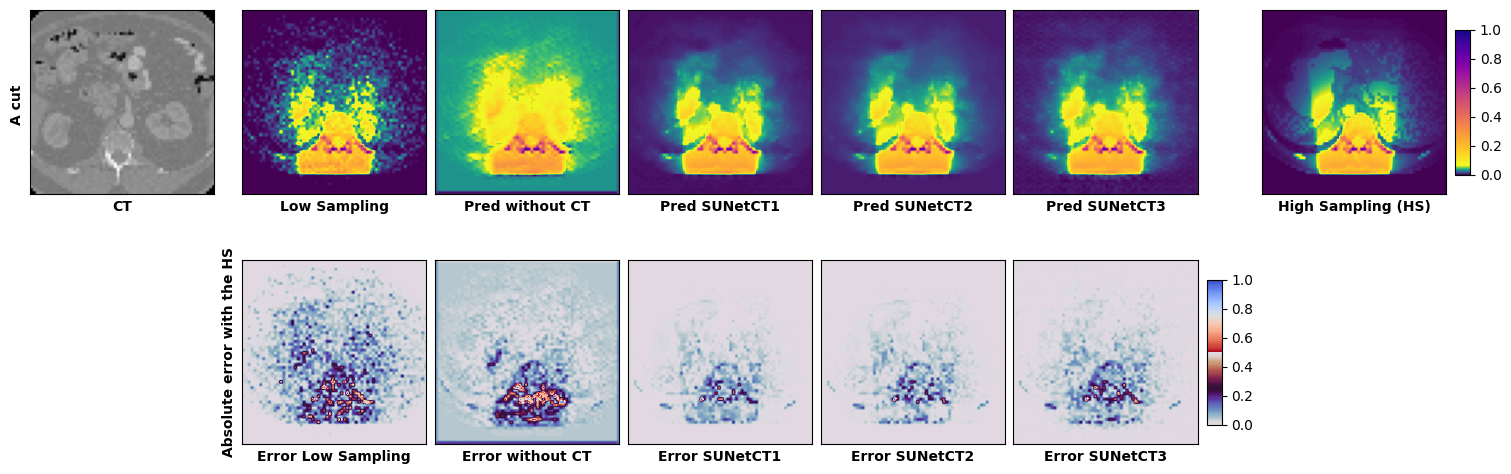

In [305]:
ind = random.randint(0, 63)
print(ind)

ct = ct_data[ind, :, :].squeeze()
low_im = low_data[ind, :, :].squeeze()
high_im = label[ind, :, :].squeeze()
pred_without_ct = pred_without_ct_data[ind, :, :].squeeze()
pred_ct_beginning = pred_ct_beginning_data[ind, :, :].squeeze()
pred_ct_inside = pred_ct_inside_data[ind, :, :].squeeze()
pred_ct_beginning_inside = pred_ct_beginning_inside_data[ind, :, :].squeeze()

##### Une mode de CMP############
top = cm.get_cmap('viridis', 64)
bottom = cm.get_cmap('plasma', 960)
newcolors = np.vstack((top(np.linspace(0, 1, 64)),
                    bottom(np.linspace(1, 0, 960))))
newcmp = ListedColormap(newcolors, name='MonteCarlo')

top = cm.get_cmap('twilight', 64)
bottom = cm.get_cmap('coolwarm', 960)
newcolors_error = np.vstack((top(np.linspace(0, 1, 64)),
                    bottom(np.linspace(1, 0, 64))))
newcmp_error = ListedColormap(newcolors_error, name='AbsoluteError')

fig1 = plt.figure(constrained_layout=True, figsize=(15, 5))
spec = gridspec.GridSpec(ncols=7, nrows=2, figure=fig1)
######
ax1 = fig1.add_subplot(spec[0, 0])
plt.imshow(ct, interpolation=None, cmap='gray')
plt.ylabel('A cut ',fontweight='bold')
plt.xlabel('CT',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax1a = fig1.add_subplot(spec[0, 1])
plt.imshow(low_im, interpolation=None, cmap=newcmp)
#plt.ylabel('Une coupe de bassin',fontweight='bold')
plt.xlabel('Low Sampling',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax1b = fig1.add_subplot(spec[0, 2])
plt.imshow(torch.detach(pred_without_ct), interpolation=None, cmap=newcmp)
plt.xlabel('Pred without CT',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax1c = fig1.add_subplot(spec[0, 3])
plt.imshow(torch.detach(pred_ct_beginning), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SUNetCT1',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax1d = fig1.add_subplot(spec[0, 4])
plt.imshow(torch.detach(pred_ct_inside), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SUNetCT2',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax1e = fig1.add_subplot(spec[0, 5])
plt.imshow(torch.detach(pred_ct_beginning_inside), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SUNetCT3',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax2 = fig1.add_subplot(spec[0, 6])
plt.imshow(high_im, interpolation=None, cmap=newcmp)
plt.xlabel('High Sampling (HS)',fontweight='bold')
# plt.colorbar(aspect=50)
plt.xticks([], [])
plt.yticks([], [])

ax3a = fig1.add_subplot(spec[1, 1])
plt.imshow(np.absolute(high_im - low_im), interpolation=None, cmap=newcmp_error)
plt.ylabel('Absolute error with the HS',fontweight='bold')
plt.xlabel('Error Low Sampling',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax3b = fig1.add_subplot(spec[1, 2])
plt.imshow(np.absolute(torch.detach(high_im - pred_without_ct)), interpolation=None, cmap=newcmp_error)
plt.xlabel('Error without CT',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax3c = fig1.add_subplot(spec[1, 3])
plt.imshow(np.absolute(torch.detach(high_im - pred_ct_beginning)), interpolation=None, cmap=newcmp_error)
plt.xlabel('Error SUNetCT1',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax3d = fig1.add_subplot(spec[1, 4])
plt.imshow(np.absolute(torch.detach(high_im - pred_ct_inside)), interpolation=None, cmap=newcmp_error)
plt.xlabel('Error SUNetCT2',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax3e = fig1.add_subplot(spec[1, 5])
plt.imshow(np.absolute(torch.detach(high_im - pred_ct_beginning_inside)), interpolation=None, cmap=newcmp_error)
plt.xlabel('Error SUNetCT3',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

###########
plt.colorbar(cm.ScalarMappable(cmap=newcmp), ax = (ax2), fraction = 0.4, aspect = 10, shrink = 0.6)
plt.colorbar(cm.ScalarMappable(cmap=newcmp_error), ax = (ax3e), fraction = 0.4, aspect = 10, shrink = 0.6)
plt.show()


In [205]:
inds = random.choices(range(len(dataloader_test) - 1), k=3)
print(inds)


[4, 1, 2]


[6, 41, 2]


/tmp/ipykernel_279876/2388667330.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('viridis', 64)
/tmp/ipykernel_279876/2388667330.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('plasma', 960)


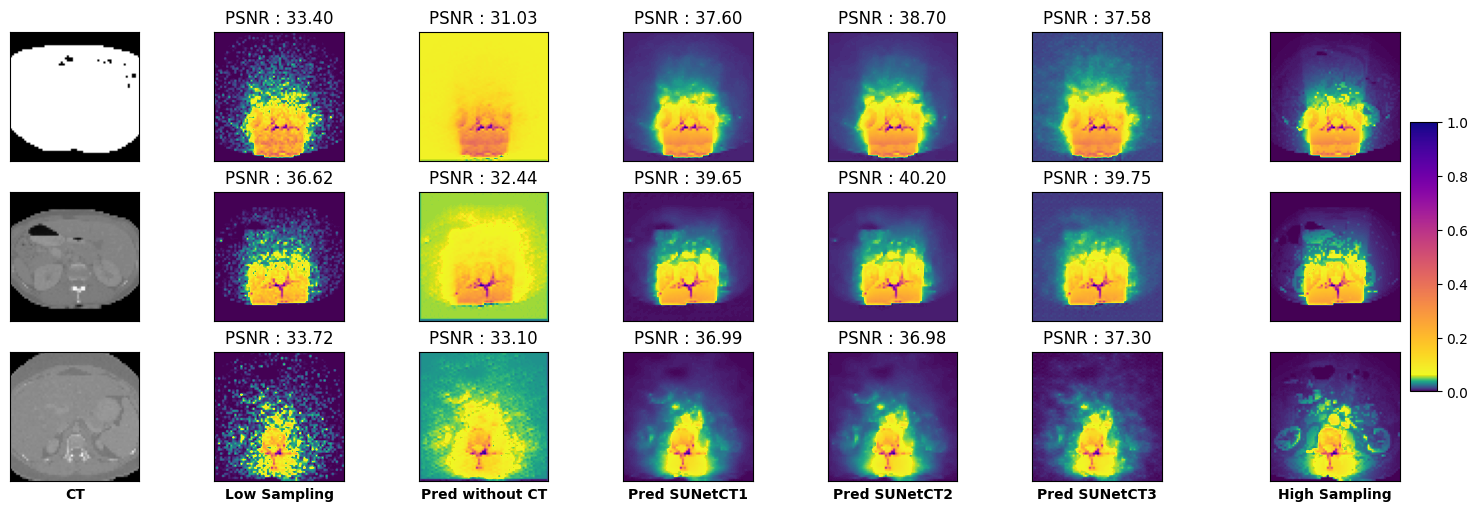

In [289]:
inds = random.choices(range(64), k= 3)
print(inds)

##### Une mode de CMP############
top = cm.get_cmap('viridis', 64)
bottom = cm.get_cmap('plasma', 960)
newcolors = np.vstack((top(np.linspace(0, 1, 64)),
                    bottom(np.linspace(1, 0, 960))))
newcmp = ListedColormap(newcolors, name='MonteCarlo')

fig1 = plt.figure(constrained_layout=True, figsize=(15, 5))
spec = gridspec.GridSpec(ncols=7, nrows=3, figure=fig1)
# fig1.set_constrained_layout_pads(wspace=1, hspace=100)
######

ind = inds[0]
ct = ct_data[ind, :, :].squeeze()
low_im = low_data[ind, :, :].squeeze()
high_im = label[ind, :, :].squeeze()
pred_without_ct = pred_without_ct_data[ind, :, :].squeeze()
pred_ct_beginning = pred_ct_beginning_data[ind, :, :].squeeze()
pred_ct_inside = pred_ct_inside_data[ind, :, :].squeeze()
pred_ct_beginning_inside = pred_ct_beginning_inside_data[ind, :, :].squeeze()

ax1 = fig1.add_subplot(spec[0,0])
plt.imshow(ct, interpolation=None, cmap='gray')
# plt.ylabel('Une coupe de bassin',fontweight='bold')
# plt.xlabel('CT',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax1a = fig1.add_subplot(spec[0,1])
plt.imshow(low_im, interpolation=None, cmap=newcmp)
#plt.ylabel('Une coupe de bassin',fontweight='bold')
# plt.xlabel('Low Sampling',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(low_im, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1b = fig1.add_subplot(spec[0,2])
plt.imshow(torch.detach(pred_without_ct), interpolation=None, cmap=newcmp)
# plt.xlabel('Pred without CT',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_without_ct, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1c = fig1.add_subplot(spec[0,3])
plt.imshow(torch.detach(pred_ct_beginning), interpolation=None, cmap=newcmp)
# plt.xlabel('Pred SUNetCT1',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_beginning, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1d = fig1.add_subplot(spec[0,4])
plt.imshow(torch.detach(pred_ct_inside), interpolation=None, cmap=newcmp)
# plt.xlabel('Pred SUNetCT2',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_inside, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1e = fig1.add_subplot(spec[0,5])
plt.imshow(torch.detach(pred_ct_beginning_inside), interpolation=None, cmap=newcmp)
# plt.xlabel('Pred SUNetCT3',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_beginning_inside, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax2 = fig1.add_subplot(spec[0,6])
plt.imshow(high_im, interpolation=None, cmap=newcmp)
# plt.xlabel('High Sampling',fontweight='bold')
# plt.colorbar(aspect=50)
plt.xticks([], [])
plt.yticks([], [])

###########IND2
ind = inds[1]
ct = ct_data[ind, :, :].squeeze()
low_im = low_data[ind, :, :].squeeze()
high_im = label[ind, :, :].squeeze()
pred_without_ct = pred_without_ct_data[ind, :, :].squeeze()
pred_ct_beginning = pred_ct_beginning_data[ind, :, :].squeeze()
pred_ct_inside = pred_ct_inside_data[ind, :, :].squeeze()
pred_ct_beginning_inside = pred_ct_beginning_inside_data[ind, :, :].squeeze()


ax3 = fig1.add_subplot(spec[1,0])
plt.imshow(ct, interpolation=None, cmap='gray')
# plt.ylabel('Une coupe de bassin',fontweight='bold')
# plt.xlabel('CT',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax4a = fig1.add_subplot(spec[1,1])
plt.imshow(low_im, interpolation=None, cmap=newcmp)
#plt.ylabel('Une coupe de bassin',fontweight='bold')
# plt.xlabel('Low Sampling',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(low_im, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax4b = fig1.add_subplot(spec[1,2])
plt.imshow(torch.detach(pred_without_ct), interpolation=None, cmap=newcmp)
# plt.xlabel('Pred without CT',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_without_ct, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax4c = fig1.add_subplot(spec[1,3])
plt.imshow(torch.detach(pred_ct_beginning), interpolation=None, cmap=newcmp)
# plt.xlabel('Pred SUNetCT1',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_beginning, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax4d = fig1.add_subplot(spec[1,4])
plt.imshow(torch.detach(pred_ct_inside), interpolation=None, cmap=newcmp)
# plt.xlabel('Pred SUNetCT2',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_inside, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax4e = fig1.add_subplot(spec[1,5])
plt.imshow(torch.detach(pred_ct_beginning_inside), interpolation=None, cmap=newcmp)
# plt.xlabel('Pred SUNetCT3',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_beginning_inside, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax5 = fig1.add_subplot(spec[1,6])
plt.imshow(high_im, interpolation=None, cmap=newcmp)
# plt.xlabel('High Sampling',fontweight='bold')
# plt.colorbar(aspect=50)
plt.xticks([], [])
plt.yticks([], [])


########## IND 3
ind = inds[2]
ct = ct_data[ind, :, :].squeeze()
low_im = low_data[ind, :, :].squeeze()
high_im = label[ind, :, :].squeeze()
pred_without_ct = pred_without_ct_data[ind, :, :].squeeze()
pred_ct_beginning = pred_ct_beginning_data[ind, :, :].squeeze()
pred_ct_inside = pred_ct_inside_data[ind, :, :].squeeze()
pred_ct_beginning_inside = pred_ct_beginning_inside_data[ind, :, :].squeeze()

ax6 = fig1.add_subplot(spec[2,0])
plt.imshow(ct, interpolation=None, cmap='gray')
# plt.ylabel('Une coupe de bassin',fontweight='bold')
plt.xlabel('CT',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax7a = fig1.add_subplot(spec[2,1])
plt.imshow(low_im, interpolation=None, cmap=newcmp)
#plt.ylabel('Une coupe de bassin',fontweight='bold')
plt.xlabel('Low Sampling',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(low_im, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax7b = fig1.add_subplot(spec[2,2])
plt.imshow(torch.detach(pred_without_ct), interpolation=None, cmap=newcmp)
plt.xlabel('Pred without CT',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_without_ct, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax7c = fig1.add_subplot(spec[2,3])
plt.imshow(torch.detach(pred_ct_beginning), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SUNetCT1',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_beginning, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax7d = fig1.add_subplot(spec[2,4])
plt.imshow(torch.detach(pred_ct_inside), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SUNetCT2',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_inside, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax7e = fig1.add_subplot(spec[2,5])
plt.imshow(torch.detach(pred_ct_beginning_inside), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SUNetCT3',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_ct_beginning_inside, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax8 = fig1.add_subplot(spec[2,6])
plt.imshow(high_im, interpolation=None, cmap=newcmp)
plt.xlabel('High Sampling',fontweight='bold')
# plt.colorbar(aspect=50)
plt.xticks([], [])
plt.yticks([], [])


###########
plt.colorbar(cm.ScalarMappable(cmap=newcmp), ax = (ax2, ax5, ax8), fraction = 0.4, aspect = 10, shrink = 0.6)
plt.show()


In [ ]:
inds = random.choices(range(len(dataloader_test) - 1), k= 3)
print(inds)

##### Une mode de CMP############
top = cm.get_cmap('viridis', 64)
bottom = cm.get_cmap('plasma', 960)
newcolors = np.vstack((top(np.linspace(0, 1, 64)),
                    bottom(np.linspace(1, 0, 960))))
newcmp = ListedColormap(newcolors, name='MonteCarlo')

fig1 = plt.figure(constrained_layout=True, figsize=(15, 5))
spec = gridspec.GridSpec(ncols=7, nrows=3, figure=fig1)
######

for i in range(3): 
    


In [70]:
reload(utilitaires)
utilitaires.function_for_comparison(path, dataloader_val, 5, model_sunet, CT=CT)

In [74]:
utilitaires.psnr_min_mean_max(dataloader_test, path, model_sunet, batch_size)

/home/ensai/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(


(29.197641372680664, 34.32208270728588, 38.031471252441406)

# SWINIR

### With CT as feature 


### Win8 et Embed36 et Epo300 et MSE

In [33]:
CT = "feature"                    # "input", "feature", or None
upscale = 2                     # Upscale factor (U) = 4
window_size = 8                # Window size (W)
embed_dim = 36                  # Embedding dimension (D) = 96
num_heads = [6] 
depths = [6]                        # Number of encoder layers (L) = 4
in_channels = (2 if CT=="input" else 1)                 # Number of channels for input images
input_size = 64  
shift_size = window_size // 2   #  Shift size (S)
num_features = 64      


epochs = 300             # Number of epochs
base_lr = 8e-4          # Base LR
batch_size = 64         # Penser à rendre le 64 normal
loss_fn = nn.MSELoss()
height = width = 64


device = 'cpu'
#input_channels = 2 if CT else 1  # Number of channels for input images
input_channels =2

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Device :", device)
print("Number of channel :", in_channels)
print("CT :", CT)

Device : cpu
Number of channel : 1
CT : feature


In [34]:
from Models_Architectures import SwinIR_CT
# Définition des modèles
# Parameters 

model_swinir_ct_emb_36_win_8_epo_300 = SwinIR_CT.SwinIR(upscale=1, img_size=(height, width),
                window_size=window_size, img_range=1., depths=depths, in_chans=in_channels, # le nombre de channels dépend directement du ct
                embed_dim=embed_dim, num_heads=num_heads, mlp_ratio=2, upsampler='', ct=CT)
model_swinir_ct_emb_36_win_8_epo_300.to(device)
print(model_swinir_ct_emb_36_win_8_epo_300)               

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model_swinir_ct_emb_36_win_8_epo_300.parameters(), lr=base_lr)

# print('FLOPs: %.4f G' % (model_swinir_ct_emb_36_win_8_epo_300.flops() / 1e9))
print('Number of parameters: %d' % (sum(p.numel() for p in model_swinir_ct_emb_36_win_8_epo_300.parameters())))
# print('Models parameters : ', model_swinir_ct_emb_36_win_8_epo_300)

SwinIR(
  (conv_first): Conv2d(1, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((36,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=36, input_resolution=(64, 64), depth=6
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=36, input_resolution=(64, 64), num_heads=6, window_size=8, shift_size=0, mlp_ratio=2
            (norm1): LayerNorm((36,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=36, out_features=108, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=36, out_features=36, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (dr

In [35]:
reload(utilitaires)
path1 = "Saved_models/model_SwinIR_with_CT_asfeature_batch64_epo300_wins8_embed_dim36.pth"

model_swinir_ct_emb_36_win_8_epo_300.load_state_dict(torch.load(path1))
print('Number of parameters: %d' % (sum(p.numel() for p in model_swinir_ct_emb_36_win_8_epo_300.parameters())))

Number of parameters: 97589


In [36]:
utilitaires.psnr_min_mean_max(dataloader_test, path1, model_swinir_ct_emb_36_win_8_epo_300, batch_size)

/home/ensai/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(


(29.164377212524414, 38.03138797879219, 45.109039306640625)

### With CT as feature 

### Win8 et Embed60 et Epo300 et MSE

In [37]:
CT = "feature"                    # "input", "feature", or None
upscale = 2                     # Upscale factor (U) = 4
window_size = 8                # Window size (W)
embed_dim = 60                  # Embedding dimension (D) = 96
num_heads = [6] 
depths = [6]                        # Number of encoder layers (L) = 4
in_channels = (2 if CT=="input" else 1)                 # Number of channels for input images
input_size = 64  
shift_size = window_size // 2   #  Shift size (S)
num_features = 64      


epochs = 300             # Number of epochs
base_lr = 8e-4          # Base LR
batch_size = 64         # Penser à rendre le 64 normal
loss_fn = nn.MSELoss()
height = width = 64


device = 'cpu'
#input_channels = 2 if CT else 1  # Number of channels for input images
input_channels =2

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Device :", device)
print("Number of channel :", in_channels)
print("CT :", CT)

Device : cpu
Number of channel : 1
CT : feature


In [38]:
from Models_Architectures import SwinIR_CT
# Définition des modèles
# Parameters 

model_swinir_ct_emb_60_win_8_epo_300 = SwinIR_CT.SwinIR(upscale=1, img_size=(height, width),
                window_size=window_size, img_range=1., depths=depths, in_chans=in_channels, # le nombre de channels dépend directement du ct
                embed_dim=embed_dim, num_heads=num_heads, mlp_ratio=2, upsampler='', ct=CT)
model_swinir_ct_emb_60_win_8_epo_300.to(device)
print(model_swinir_ct_emb_60_win_8_epo_300)               

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model_swinir_ct_emb_60_win_8_epo_300.parameters(), lr=base_lr)

# print('FLOPs: %.4f G' % (model_swinir_ct_emb_60_win_8_epo_300.flops() / 1e9))
print('Number of parameters: %d' % (sum(p.numel() for p in model_swinir_ct_emb_60_win_8_epo_300.parameters())))
# print('Models parameters : ', model_swinir_ct_emb_60_win_8_epo_300)

SwinIR(
  (conv_first): Conv2d(1, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=60, input_resolution=(64, 64), depth=6
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=60, input_resolution=(64, 64), num_heads=6, window_size=8, shift_size=0, mlp_ratio=2
            (norm1): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=60, out_features=180, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=60, out_features=60, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (dr

In [39]:
reload(utilitaires)
path2 = "Saved_models/model_SwinIR_with_CT_asfeature_batch64_epo300_wins8.pth"

model_swinir_ct_emb_60_win_8_epo_300.load_state_dict(torch.load(path2))
print('Number of parameters: %d' % (sum(p.numel() for p in model_swinir_ct_emb_60_win_8_epo_300.parameters())))

Number of parameters: 252269


In [41]:
utilitaires.psnr_min_mean_max(dataloader_test, path2, model_swinir_ct_emb_60_win_8_epo_300, batch_size)

/home/ensai/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(


(29.08003044128418, 38.085219624638555, 44.4022331237793)

### Représentation graphique

In [45]:
for X, y in dataloader_test:
    data = X
    low_data = data[:, 0, :, :].unsqueeze(1)
    ct_data = data[:, 1, :, :]
    label = y
    break

model_swinir_ct_emb_36_win_8_epo_300.eval()
model_swinir_ct_emb_60_win_8_epo_300.eval()

with torch.no_grad():
    pred_embed_36_data = model_swinir_ct_emb_36_win_8_epo_300(data)
    pred_embed_60_data = model_swinir_ct_emb_60_win_8_epo_300(data)

In [94]:
ind = random.randint(0, 63)
print(ind)

45


<ipython-input-95-7a985686e381>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('viridis', 64)
<ipython-input-95-7a985686e381>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('plasma', 960)
<ipython-input-95-7a985686e381>:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig1.colorbar(cm.ScalarMappable(cmap=newcmp), pad=0.04, fraction = 0.1, aspect = 10, shrink = 0.5)


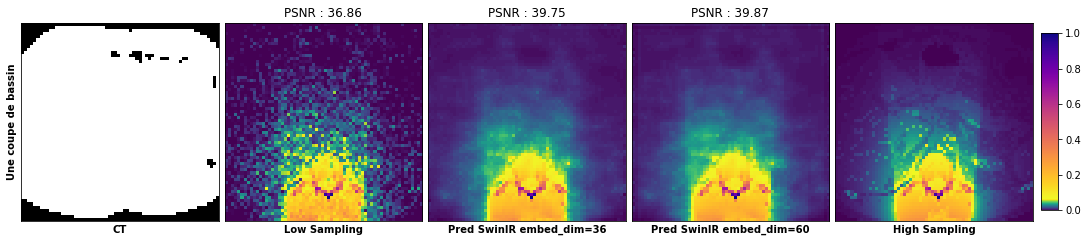

In [95]:
# ind = 50 

ct = ct_data[ind, :, :].squeeze()
low_im = low_data[ind, :, :].squeeze()
high_im = label[ind, :, :].squeeze()
pred_embed_36 = pred_embed_36_data[ind, :, :].squeeze()
pred_embed_60 = pred_embed_60_data[ind, :, :].squeeze()

##### Une mode de CMP############
top = cm.get_cmap('viridis', 64)
bottom = cm.get_cmap('plasma', 960)
newcolors = np.vstack((top(np.linspace(0, 1, 64)),
                    bottom(np.linspace(1, 0, 960))))
newcmp = ListedColormap(newcolors, name='MonteCarlo')

fig1 = plt.figure(constrained_layout=True, figsize=(15, 5))
spec = gridspec.GridSpec(ncols=5, nrows=1, figure=fig1)
######

ax1 = fig1.add_subplot(spec[0])
plt.imshow(ct, interpolation=None, cmap='gray')
plt.ylabel('Une coupe de bassin',fontweight='bold')
plt.xlabel('CT',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax1a = fig1.add_subplot(spec[1])
plt.imshow(low_im, interpolation=None, cmap=newcmp)
#plt.ylabel('Une coupe de bassin',fontweight='bold')
plt.xlabel('Low Sampling',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(low_im, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1b = fig1.add_subplot(spec[2])
plt.imshow(torch.detach(pred_embed_36), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SwinIR embed_dim=36',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_embed_36, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1c = fig1.add_subplot(spec[3])
plt.imshow(torch.detach(pred_embed_60), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SwinIR embed_dim=60',fontweight='bold')
plt.title(f'PSNR : {utilitaires.psnr(pred_embed_60, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax2 = fig1.add_subplot(spec[4])
plt.imshow(high_im, interpolation=None, cmap=newcmp)
plt.xlabel('High Sampling',fontweight='bold')
# plt.colorbar(aspect=50)
plt.xticks([], [])
plt.yticks([], [])
###########
fig1.colorbar(cm.ScalarMappable(cmap=newcmp), pad=0.04, fraction = 0.1, aspect = 10, shrink = 0.5)
plt.show()


In [ ]:
50
25, 44


47
62

In [84]:
ind = random.randint(0, 63)
print(ind)

1


<ipython-input-102-2969f5eaa88f>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('viridis', 64)
<ipython-input-102-2969f5eaa88f>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('plasma', 960)
<ipython-input-102-2969f5eaa88f>:101: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig1.colorbar(cm.ScalarMappable(cmap=newcmp), pad=0.04, fraction = 0.1, aspect = 10, shrink = 0.8)


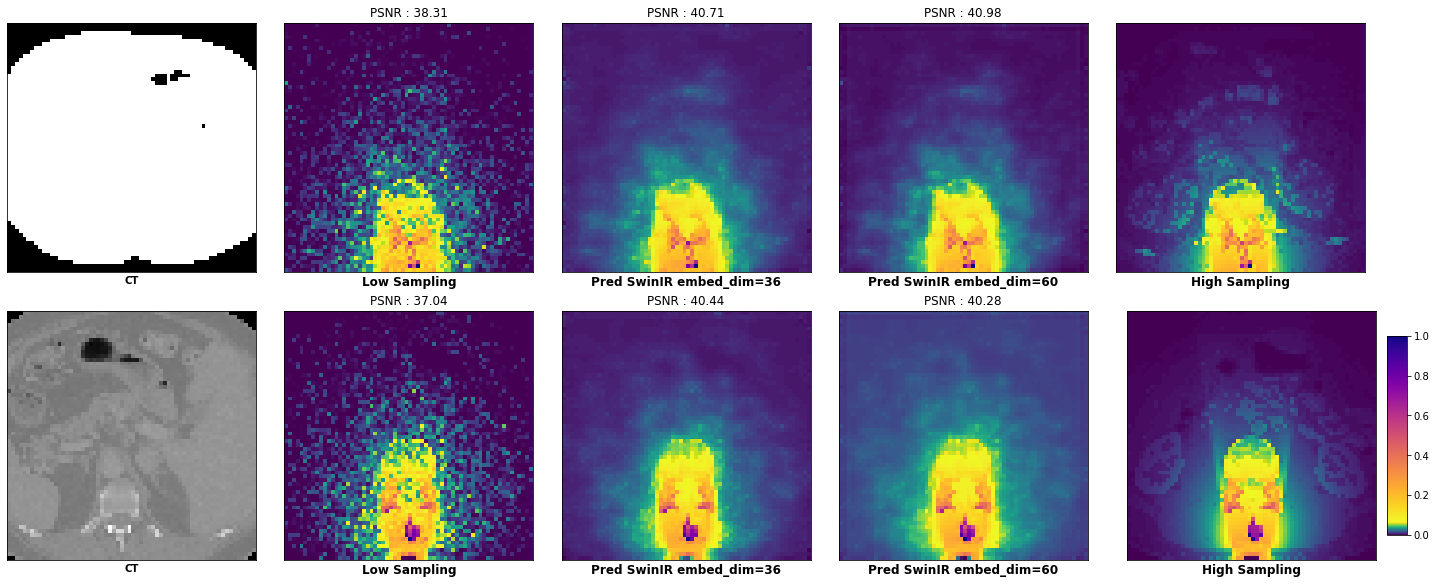

In [102]:
ind = 5 

ct = ct_data[ind, :, :].squeeze()
low_im = low_data[ind, :, :].squeeze()
high_im = label[ind, :, :].squeeze()
pred_embed_36 = pred_embed_36_data[ind, :, :].squeeze()
pred_embed_60 = pred_embed_60_data[ind, :, :].squeeze()

##### Une mode de CMP############
top = cm.get_cmap('viridis', 64)
bottom = cm.get_cmap('plasma', 960)
newcolors = np.vstack((top(np.linspace(0, 1, 64)),
                    bottom(np.linspace(1, 0, 960))))
newcmp = ListedColormap(newcolors, name='MonteCarlo')

fig1 = plt.figure(constrained_layout=True, figsize=(20, 8))
spec = gridspec.GridSpec(ncols=5, nrows=2, figure=fig1)
######

ax1 = fig1.add_subplot(spec[0, 0])
plt.imshow(ct, interpolation=None, cmap='gray')
# plt.ylabel('Une coupe de bassin',fontweight='bold', fontsize=12)
plt.xlabel('CT',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax1a = fig1.add_subplot(spec[0, 1])
plt.imshow(low_im, interpolation=None, cmap=newcmp)
#plt.ylabel('Une coupe de bassin',fontweight='bold')
plt.xlabel('Low Sampling',fontweight='bold', fontsize=12)
plt.title(f'PSNR : {utilitaires.psnr(low_im, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1b = fig1.add_subplot(spec[0, 2])
plt.imshow(torch.detach(pred_embed_36), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SwinIR embed_dim=36',fontweight='bold', fontsize=12)
plt.title(f'PSNR : {utilitaires.psnr(pred_embed_36, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1c = fig1.add_subplot(spec[0, 3])
plt.imshow(torch.detach(pred_embed_60), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SwinIR embed_dim=60',fontweight='bold', fontsize=12)
plt.title(f'PSNR : {utilitaires.psnr(pred_embed_60, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax1d = fig1.add_subplot(spec[0, 4])
plt.imshow(high_im, interpolation=None, cmap=newcmp)
plt.xlabel('High Sampling',fontweight='bold', fontsize=12)
# plt.colorbar(aspect=50)
plt.xticks([], [])
plt.yticks([], [])


ind = 47
ct = ct_data[ind, :, :].squeeze()
low_im = low_data[ind, :, :].squeeze()
high_im = label[ind, :, :].squeeze()
pred_embed_36 = pred_embed_36_data[ind, :, :].squeeze()
pred_embed_60 = pred_embed_60_data[ind, :, :].squeeze()

ax2 = fig1.add_subplot(spec[1, 0])
plt.imshow(ct, interpolation=None, cmap='gray')
# plt.ylabel('Une coupe de bassin',fontweight='bold', fontsize=12)
plt.xlabel('CT',fontweight='bold')
plt.xticks([], [])
plt.yticks([], [])

ax2a = fig1.add_subplot(spec[1, 1])
plt.imshow(low_im, interpolation=None, cmap=newcmp)
#plt.ylabel('Une coupe de bassin',fontweight='bold')
plt.xlabel('Low Sampling',fontweight='bold', fontsize=12)
plt.title(f'PSNR : {utilitaires.psnr(low_im, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax2b = fig1.add_subplot(spec[1, 2])
plt.imshow(torch.detach(pred_embed_36), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SwinIR embed_dim=36',fontweight='bold', fontsize=12)
plt.title(f'PSNR : {utilitaires.psnr(pred_embed_36, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax2c = fig1.add_subplot(spec[1, 3])
plt.imshow(torch.detach(pred_embed_60), interpolation=None, cmap=newcmp)
plt.xlabel('Pred SwinIR embed_dim=60',fontweight='bold', fontsize=12)
plt.title(f'PSNR : {utilitaires.psnr(pred_embed_60, high_im, 1):.2f}')
plt.xticks([], [])
plt.yticks([], [])

ax2d = fig1.add_subplot(spec[1, 4])
plt.imshow(high_im, interpolation=None, cmap=newcmp)
plt.xlabel('High Sampling',fontweight='bold', fontsize=12)
# plt.colorbar(aspect=50)
plt.xticks([], [])
plt.yticks([], [])

###########
fig1.colorbar(cm.ScalarMappable(cmap=newcmp), pad=0.04, fraction = 0.1, aspect = 10, shrink = 0.8)
plt.show()
